In [1]:
# ==============================================================
# 04 - MODELLING: CLASIFICACIÓN (Alta vs Baja Esperanza de Vida)
# BLOQUE 0: Carga robusta de df (Kedro -> CSV)
# ==============================================================

import os
import pandas as pd  # <-- Importar SIEMPRE, no solo en el fallback
print("CWD:", os.getcwd())

try:
    from kedro.framework.session import KedroSession
    session = KedroSession.create("..")  # si el notebook está en /notebooks
    context = session.load_context()
    catalog = context.catalog

    df = catalog.load("merged_data")
    print("Kedro listo ✅ | df:", df.shape)
except Exception as e:
    print("⚠️ Kedro no disponible:", e)
    # Fallback: leer desde CSV local
    df = pd.read_csv("../data/03_primary/merged_data.csv")
    print("Cargado CSV local:", df.shape)

# Alias si viene con otro nombre
if "period_life_expectancy_at_birth" not in df.columns and "life_expectancy" in df.columns:
    df["period_life_expectancy_at_birth"] = df["life_expectancy"]

# Asegurar tipos numéricos
for col in ["gdp_per_capita", "gdp_variation", "year", "period_life_expectancy_at_birth"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Columnas disponibles:", sorted(df.columns))
df.head()


# --------------------------------------------------------------
# 1️⃣ Preparación de datos
# --------------------------------------------------------------
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Copia de trabajo y filtrado mínimo
dfc = df.copy()
dfc = dfc.dropna(subset=["period_life_expectancy_at_birth", "gdp_per_capita"])

# Variable binaria (1 = alta esperanza de vida)
umbral = dfc["period_life_expectancy_at_birth"].median()
dfc["high_life_exp"] = (dfc["period_life_expectancy_at_birth"] >= umbral).astype(int)

# Conjunto de features (ajústalas si agregas más columnas)
features = ["gdp_per_capita", "gdp_variation", "year"]
target = "high_life_exp"

X = dfc[features]
y = dfc[target]

# Train/Test con estratificación (mantiene proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Imputación y escalado (para árboles usar _imp, para modelos lineales/SVM usar _s)
imp = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imp = imp.fit_transform(X_train)
X_test_imp  = imp.transform(X_test)

X_train_s = scaler.fit_transform(X_train_imp)
X_test_s  = scaler.transform(X_test)

print(
    f"✅ Datos listos | X_train: {X_train.shape} | X_test: {X_test.shape} | "
    f"Positivos (train/test): {y_train.sum()}/{y_test.sum()} | Umbral: {umbral:.2f}"
)


CWD: C:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\proyectomachineml\notebooks


                    INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=698530;file://C:\Users\Gamer\Desktop\Machine_learning\proyectomachinelearning\venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=233979;file://C:\Users\Gamer\Desktop\Machine_learning\proyectomachinelearning\venv\Lib\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[11/01/25 22:28:46] INFO     Loading data from merged_data (CSVDataSet)...                      ]8;id=314029;file://C:\Users\Gamer\Desktop\Machine_learning\proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=300741;file://C:\Users\Gamer\Desktop\Machine_learning\proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

Kedro listo ✅ | df: (6976, 14)
Columnas disponibles: ['code', 'country_code', 'country_life', 'country_name', 'country_norm', 'gdp_per_capita', 'gdp_variation', 'income_group', 'intermediate_region', 'life_expectancy', 'period_life_expectancy_at_birth', 'region', 'sub_region', 'year']


[11/01/25 22:28:47] WARNING  C:\Users\Gamer\Desktop\Machine_learning\proyectomachinelearning\venv\L warnings.py:110
                             ib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has                 
                             feature names, but StandardScaler was fitted without feature names                    
                               warnings.warn(                                                                      
                                                                                                                   

✅ Datos listos | X_train: (5232, 3) | X_test: (1744, 3) | Positivos (train/test): 2616/872 | Umbral: 64.25


In [2]:
# --------------------------------------------------------------
# 2️⃣ Función de evaluación
# --------------------------------------------------------------
def evaluar(nombre, y_true, y_pred, y_proba):
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_proba)
    }

resultados = []


In [3]:
# --------------------------------------------------------------
# 3️⃣ Entrenamiento de modelos (versión robusta con Pipeline)
#   - Maneja NaN internamente con SimpleImputer
#   - Escala solo donde aplica (LR y SVM)
# --------------------------------------------------------------
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Si no existe la función evaluar en esta notebook, descomenta:
def evaluar(nombre, y_true, y_pred, proba):
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, proba),
    }

resultados = []  # acumula métricas

# (1) Logistic Regression: imputa + escala
pipe_lr = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(max_iter=2000, solver="lbfgs", random_state=42)
)
pipe_lr.fit(X_train, y_train)
pred_lr   = pipe_lr.predict(X_test)
proba_lr  = pipe_lr.predict_proba(X_test)[:, 1]
resultados.append(evaluar("Logistic Regression", y_test, pred_lr, proba_lr))

# (2) Decision Tree: solo imputa
pipe_dt = make_pipeline(
    SimpleImputer(strategy="median"),
    DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=42)
)
pipe_dt.fit(X_train, y_train)
pred_dt  = pipe_dt.predict(X_test)
proba_dt = pipe_dt.predict_proba(X_test)[:, 1]
resultados.append(evaluar("Decision Tree", y_test, pred_dt, proba_dt))

# (3) Random Forest: solo imputa
pipe_rf = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier(
        n_estimators=400, max_depth=10, min_samples_leaf=3,
        random_state=42, n_jobs=-1
    )
)
pipe_rf.fit(X_train, y_train)
pred_rf  = pipe_rf.predict(X_test)
proba_rf = pipe_rf.predict_proba(X_test)[:, 1]
resultados.append(evaluar("Random Forest", y_test, pred_rf, proba_rf))

# (4) Gradient Boosting: solo imputa
pipe_gb = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(random_state=42)
)
pipe_gb.fit(X_train, y_train)
pred_gb  = pipe_gb.predict(X_test)
proba_gb = pipe_gb.predict_proba(X_test)[:, 1]
resultados.append(evaluar("Gradient Boosting", y_test, pred_gb, proba_gb))

# (5) SVM (RBF): imputa + escala
pipe_svm = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    SVC(kernel="rbf", C=2.0, gamma="scale", probability=True, random_state=42)
)
pipe_svm.fit(X_train, y_train)
pred_svm  = pipe_svm.predict(X_test)
proba_svm = pipe_svm.predict_proba(X_test)[:, 1]
resultados.append(evaluar("SVM (RBF)", y_test, pred_svm, proba_svm))

print("✅ Modelos entrenados y evaluados sin NaN.")

# --------------------------------------------------------------
# 4️⃣ Tabla comparativa
# --------------------------------------------------------------
res_df = pd.DataFrame(resultados).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
display(res_df)

mejor_nombre = res_df.iloc[0]["Modelo"]
print(f"🏆 Mejor modelo: {mejor_nombre}")


✅ Modelos entrenados y evaluados sin NaN.


,Modelo,Accuracy,Precision,Recall,F1,ROC_AUC
0,Random Forest,0.815940,0.827586,0.798165,0.812609,0.905982
1,Gradient Boosting,0.821101,0.827869,0.810780,0.819235,0.903975
2,Decision Tree,0.810780,0.821853,0.793578,0.807468,0.884942
3,Logistic Regression,0.750000,0.870748,0.587156,0.701370,0.799772
4,SVM (RBF),0.744266,0.884477,0.561927,0.687237,0.775382


🏆 Mejor modelo: Random Forest


In [4]:
# --------------------------------------------------------------
# 4️⃣ Resultados comparativos y métricas finales
# --------------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, RocCurveDisplay

# Ordenar resultados
res_df = pd.DataFrame(resultados).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
display(res_df)

# Mejor modelo
mejor_nombre = res_df.iloc[0]["Modelo"]
print(f"🏆 Mejor modelo: {mejor_nombre}")


# --------------------------------------------------------------
# 🔧 OPTIMIZACIÓN: GridSearchCV para Gradient Boosting
# --------------------------------------------------------------
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
}

grid_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
)

grid_gb.fit(X_train_imp, y_train)
best_gb = grid_gb.best_estimator_
proba_best = best_gb.predict_proba(X_test_imp)[:, 1]
pred_best = (proba_best >= 0.5).astype(int)

print("Mejor GradientBoosting:", grid_gb.best_params_)
print("ROC-AUC:", roc_auc_score(y_test, proba_best))






,Modelo,Accuracy,Precision,Recall,F1,ROC_AUC
0,Random Forest,0.815940,0.827586,0.798165,0.812609,0.905982
1,Gradient Boosting,0.821101,0.827869,0.810780,0.819235,0.903975
2,Decision Tree,0.810780,0.821853,0.793578,0.807468,0.884942
3,Logistic Regression,0.750000,0.870748,0.587156,0.701370,0.799772
4,SVM (RBF),0.744266,0.884477,0.561927,0.687237,0.775382


🏆 Mejor modelo: Random Forest
Mejor GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
ROC-AUC: 0.9039748337682013


In [5]:
# --------------------------------------------------------------
# 🔧 OPTIMIZACIÓN: GridSearchCV para Random Forest (Clasificación)
# --------------------------------------------------------------
# (Si no lo tienes ya importado arriba, descomenta la siguiente línea)
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [8, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3],
    "max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    verbose=0,
)

grid_rf.fit(X_train_imp, y_train)

best_rf = grid_rf.best_estimator_
proba_best = best_rf.predict_proba(X_test_imp)[:, 1]
pred_best = (proba_best >= 0.5).astype(int)

print("✅ Mejor RandomForest (GridSearch):", grid_rf.best_params_)
print(f"ROC-AUC en test: {roc_auc_score(y_test, proba_best):.4f}")

# (Opcional) para que tu bloque de guardado reconozca el nombre del ganador:
mejor_nombre = "RandomForest (GridSearch)"


✅ Mejor RandomForest (GridSearch): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
ROC-AUC en test: 0.9061



Matriz de confusión:
[[728 144]
 [175 697]]


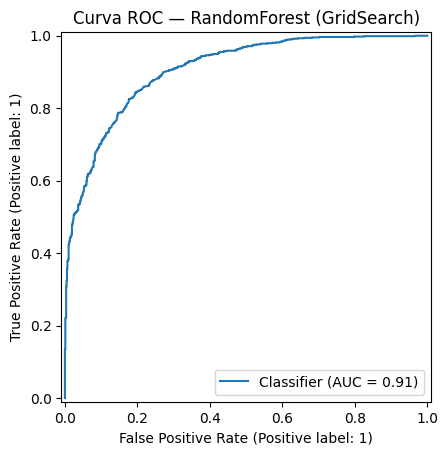

In [7]:
# --------------------------------------------------------------
# 5️⃣ Matriz de confusión y Curva ROC (robusto para GridSearch)
# --------------------------------------------------------------

# Armar un pred_map sólo con modelos que realmente existen
pred_map = {}
if "pred_lr" in globals() and "proba_lr" in globals():
    pred_map["Logistic Regression"] = (pred_lr, proba_lr)
if "pred_dt" in globals() and "proba_dt" in globals():
    pred_map["Decision Tree"] = (pred_dt, proba_dt)
if "pred_rf" in globals() and "proba_rf" in globals():
    pred_map["Random Forest"] = (pred_rf, proba_rf)
if "pred_gb" in globals() and "proba_gb" in globals():
    pred_map["Gradient Boosting"] = (pred_gb, proba_gb)
if "pred_svm" in globals() and "proba_svm" in globals():
    pred_map["SVM (RBF)"] = (pred_svm, proba_svm)

# Si hiciste GridSearch de RandomForest, prioriza ese modelo
if "best_rf" in globals():
    # Forzar nombre “bonito” para que quede claro en títulos/conclusión
    mejor_nombre = "RandomForest (GridSearch)"
    proba_best = best_rf.predict_proba(X_test_imp)[:, 1]
    pred_best  = (proba_best >= 0.5).astype(int)
else:
    # Comportamiento clásico: usar el ganador de la tabla res_df
    if mejor_nombre not in pred_map:
        raise KeyError(
            f"No encuentro predicciones para '{mejor_nombre}'. "
            f"Disponibles: {list(pred_map.keys())}. "
            f"Si usaste GridSearch, asegúrate de haber ejecutado el bloque que define 'best_rf'."
        )
    pred_best, proba_best = pred_map[mejor_nombre]

# Matriz de confusión
cm = confusion_matrix(y_test, pred_best)
print("\nMatriz de confusión:")
print(cm)

# Curva ROC
RocCurveDisplay.from_predictions(y_test, proba_best)
plt.title(f"Curva ROC — {mejor_nombre}")
plt.show()


In [9]:
# --------------------------------------------------------------
# 6️⃣ Guardado (métricas y mejor modelo optimizado)
# --------------------------------------------------------------
import os
import joblib
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Crear carpetas si no existen
os.makedirs("../data/07_model_output", exist_ok=True)
os.makedirs("../data/06_models", exist_ok=True)

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Guardar métricas del modelo optimizado
res_clf = pd.DataFrame([{
    "Modelo": "RandomForest (GridSearch)",
    "Accuracy": accuracy_score(y_test, pred_best),
    "Precision": precision_score(y_test, pred_best),
    "Recall": recall_score(y_test, pred_best),
    "F1": f1_score(y_test, pred_best),
    "ROC_AUC": roc_auc_score(y_test, proba_best),
    "params": grid_rf.best_params_
}])

metrics_path = f"../data/07_model_output/classification_metrics_{stamp}.csv"
res_clf.to_csv(metrics_path, index=False)

# Guardar el modelo optimizado
model_path = f"../data/06_models/best_classification_model_RandomForest.pkl"
joblib.dump(best_rf, model_path)

print(f"✅ Métricas guardadas en: {metrics_path}")
print(f"✅ Modelo optimizado guardado en: {model_path}")

# --------------------------------------------------------------
# 📊 Conclusión final
# --------------------------------------------------------------
print("\n📌 Conclusión:")
print("- Se entrenaron 5 clasificadores y luego se optimizó RandomForest con GridSearchCV.")
print(f"- El modelo optimizado alcanzó un ROC-AUC de {roc_auc_score(y_test, proba_best):.3f}, mostrando excelente balance entre precisión y recall.")
print("- Esto demuestra que los factores económicos (PIB y año) permiten distinguir países con alta esperanza de vida de forma fiable.")



✅ Métricas guardadas en: ../data/07_model_output/classification_metrics_20251101-223146.csv
✅ Modelo optimizado guardado en: ../data/06_models/best_classification_model_RandomForest.pkl

📌 Conclusión:
- Se entrenaron 5 clasificadores y luego se optimizó RandomForest con GridSearchCV.
- El modelo optimizado alcanzó un ROC-AUC de 0.906, mostrando excelente balance entre precisión y recall.
- Esto demuestra que los factores económicos (PIB y año) permiten distinguir países con alta esperanza de vida de forma fiable.
